# Tesseract example code

To be able to use this code, you will need to have the packages opencv (image reading and maipluation), tesseract (OCR) and pytesseract (tesseract python bindings) installed. You can install pytesseract by running the following command in your terminal:

```
pip3 install --user pytesseract
```

More information can be found at: https://pypi.org/project/pytesseract/

## Importing some modules

We start with importing som modules that will come in handy.

In [1]:
import cv2                      # Computer Vision
import numpy as np              # Vector math
import pytesseract              # OCR
import matplotlib.pyplot as plt # Plotting
%matplotlib inline

## Reading text from a file and render it to an image

For testing tesseract it can be useful to be able to create an image with text and then convert the image back to text data. We can conceptualise this as a function $f: T \rightarrow I$ from the text domain to the image domain. This will be implemented using [OpenCV](https://opencv.org/). We then define a function $g: I \rightarrow T$, as an approximation of the inverse of $f$. Tesseract will stand in for the inverse function. After these steps, we can see if we got back what we started with. The character (or word) error rate can be measured as a way to quantify the quality of $g$. For testing the robustness of $g$, we will insert some image noise between $f$ and $g$. This is the qualitative part of the lab.

First, we'll need to read some text.

In [2]:
# Read in some text
with open("Eisenhower.txt", 'r') as file:
    original_text = file.read()

print(original_text)

A vital element in keeping the peace is our military establishment.
Our arms must be mighty, ready for instant action, so that no 
potential aggressor may be tempted to risk his own destruction...

This conjunction of an immense military establishment and a large 
arms industry is new in the American experience. The total 
influence - economic, political, even spiritual - is felt in every 
city, every statehouse, every office of the federal government. We 
recognize the imperative need for this development. Yet we must not 
fail to comprehend its grave implications. Our toil, resources and 
livelihood are all involved; so is the very structure of our society.
In the councils of government, we must guard against the acquisition
of unwarranted influence, whether sought or unsought, by the 
military-industrial complex. The potential for the disastrous rise 
of misplaced power exists, and will persist. We must never let the 
weight of this combination endanger our liberties or democratic 


Now for rendering the text to an image and then crop the image to reduce the margins (our function $f$). 

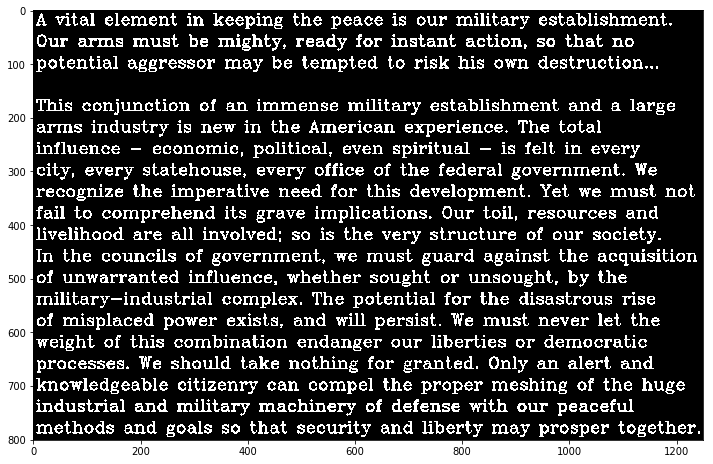

In [3]:
def render_text(texttorender, scale=1.0):
    lines = texttorender.split('\n')
    img = np.zeros((int(len(lines)*40*scale), int(np.max([len(line) for line in lines])*20*scale)))
    for n, textline in enumerate(lines):
        img = cv2.putText(img, textline, (10, int((n+1)*40*scale)), cv2.FONT_HERSHEY_COMPLEX,
                          scale, (255, 255, 255), 2, cv2.LINE_AA)
    return img

def autocrop(image):
    for axis in [0, 1]:
        s = np.sum(image>0, axis=axis)
        a = 0
        b = len(s)-1
        while s[a] == 0:
            a += 1
        a = max(a-5, 0)
        while s[b] == 0:
            b -= 1
        b = min(b+5, len(s)-1)
        if axis == 1:
            image = image[a:b+1, :]
        else:
            image = image[:, a:b+1]
    return image

def f(text_to_render, scale=1.0):
    return autocrop(render_text(text_to_render, scale=scale))

image_with_text = f(original_text)
plt.figure(figsize=(12, 12))
plt.imshow(image_with_text, cmap='gray');

Now for the function $g$ (this can take some time, depending on the available computing power).

In [4]:
extracted_text = pytesseract.image_to_string(image_with_text)
print(extracted_text)

A vital element in keeping the peace is our military establishment.
Our arms must be mighty, ready for instant action, so that no
potential aggressor may be tempted to risk his own destruction...

This conjunction of an immense military establishment and a large
arms industry is new in the American experience. The total

influence — economic, political, even spiritual — is felt in every

city, every statehouse, every office of the federal government. We
recognize the imperative need for this development. Yet we must not
fail to comprehend its grave implications. Our toil, resources and
livelihood are all involved; so is the very structure of our society.

In the councils of government, we must guard against the acquisition
of unwarranted influence, whether sought or unsought, by the
military—industrial complex. The potential for the disastrous rise

of misplaced power exists, and will persist. We must never let the
weight of this combination endanger our liberties or democratic
process

## Testing the quality

A common metric of quality of the OCR is the word error rate, i.e. the number of non-recognised words in relation to the total number of words. This can be done by flexibly matching the original text with the text returned from the OCR.

A big thanks to https://martin-thoma.com/word-error-rate-calculation/ for sharing their code on Levenshtein distance.

In [5]:
from borrowed_code import wer
print(wer.__doc__)


    Calculation of WER with Levenshtein distance.

    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.

    Parameters
    ----------
    r : list
    h : list

    Returns
    -------
    int

    Examples
    --------
    >>> wer("who is there".split(), "is there".split())
    1
    >>> wer("who is there".split(), "".split())
    3
    >>> wer("".split(), "who is there".split())
    3
    


In [6]:
print(original_text.split()[:20])
print(extracted_text.split()[:20])
we = wer(original_text.split(), extracted_text.split())
print("Word errors:", we)
print("WER:", we/max(len(original_text.split()), len(extracted_text.split())))

['A', 'vital', 'element', 'in', 'keeping', 'the', 'peace', 'is', 'our', 'military', 'establishment.', 'Our', 'arms', 'must', 'be', 'mighty,', 'ready', 'for', 'instant', 'action,']
['A', 'vital', 'element', 'in', 'keeping', 'the', 'peace', 'is', 'our', 'military', 'establishment.', 'Our', 'arms', 'must', 'be', 'mighty,', 'ready', 'for', 'instant', 'action,']
Word errors: 3
WER: 0.015228426395939087


In [7]:
print(list(original_text)[:20])
print(list(extracted_text)[:20])
ce = wer(list(original_text), list(extracted_text))
print("Character errors:", ce)
print("CER:", ce/max(len(list(original_text)), len(list(extracted_text))))

['A', ' ', 'v', 'i', 't', 'a', 'l', ' ', 'e', 'l', 'e', 'm', 'e', 'n', 't', ' ', 'i', 'n', ' ', 'k']
['A', ' ', 'v', 'i', 't', 'a', 'l', ' ', 'e', 'l', 'e', 'm', 'e', 'n', 't', ' ', 'i', 'n', ' ', 'k']
Character errors: 19
CER: 0.015007898894154818


## A real world example

This image is from an old encyclopedia.

Gutenberg [go’-], Johann (hette egentligen 
Henne Gensfleisch, men är mest känd under 
namnet G., upptaget efter en gård, som i flera 
släktled tillhört familjen), boktryckarkonstens 
uppfinnare, f. mellan 1394 och 1397 i Mainz, 
d. där 1468. Både på fädernet och mödernet 
härstammade han från gamla patriciska 
familjer. Om hans lefnadsomständigheter 
känner man icke mycket. Redan före 1430 
lämnade han Mainz, och sedermera begaf han sig 
till Strassburg, där han bevisligen uppehöll 
sig 1434 och där han under de följande åren 
sysselsatte sig med "geheime und wunderbare 
künste". 1439 uppstod mellan honom och hans 
kompanjoner en process, hvars handlingar, 
som ännu finnas i behåll, äro af stor vikt för 
historien om boktryckarkonstens ursprung. Under 
vistelsen i Strassburg företog G. sina första 
tryckningsförsök, och tanken att använda rörliga 
typer torde redan där ha uppstått hos honom. Det 
var dock först sedermera, som han använde sin 
konst för praktiska ändamål. Efter att 144

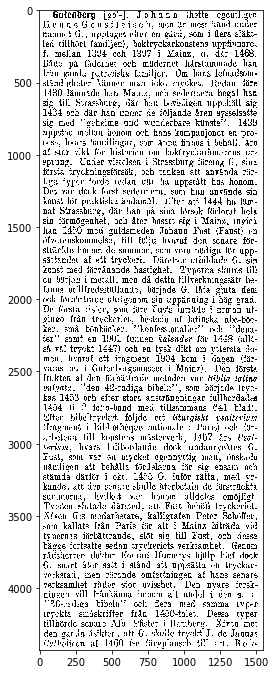

In [8]:
with open("Gutenberg.txt", 'r', encoding='utf-8') as file:
    original_text = file.read()
print(original_text)

img = cv2.imread("Gutenberg.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(4, 12))
plt.imshow(img, cmap='gray');

Now for extracting the text and calculating the error rates.

In [9]:
extracted_text = pytesseract.image_to_string(img)

we = wer(original_text.split(), extracted_text.split())
print("Word errors:", we)
print("WER:", we/max(len(original_text.split()), len(extracted_text.split())))

ce = wer(list(original_text), list(extracted_text))
print("Character errors:", ce)
print("CER:", ce/max(len(list(original_text)), len(list(extracted_text))))

Word errors: 169
WER: 0.32688588007736946
Character errors: 115
CER: 0.034659433393610606


OCR can incorporate knowledge of language in the recognition. Let's try OCR with a language model for Swedish.

In [10]:
extracted_text = pytesseract.image_to_string(img, lang='swe')

we = wer(original_text.split(), extracted_text.split())
print("Word errors:", we)
print("WER:", we/max(len(original_text.split()), len(extracted_text.split())))

ce = wer(list(original_text), list(extracted_text))
print("Character errors:", ce)
print("CER:", ce/max(len(list(original_text)), len(list(extracted_text))))

Word errors: 70
WER: 0.13513513513513514
Character errors: 122
CER: 0.03676913803496082


Unsurprisingly, the error rate for words in greatly improved.

In [11]:
# TODO Visualise the bbx data
d = pytesseract.image_to_boxes(img)
d

"G 96 4372 129 4423 0\nu 139 4372 166 4409 0\nt 172 4373 192 4423 0\ne 198 4372 224 4411 0\nn 230 4372 257 4411 0\nb 265 4372 294 4422 0\ne 300 4372 327 4410 0\nr 332 4373 358 4410 0\ng 360 4360 388 4409 0\n[ 450 4359 469 4423 0\ng 475 4357 502 4405 0\no 507 4372 532 4406 0\n’ 537 4393 548 4421 0\n- 553 4386 572 4393 0\n] 574 4359 593 4423 0\n, 607 4361 616 4381 0\nJ 678 4371 705 4421 0\no 728 4372 753 4405 0\nh 774 4372 805 4421 0\na 826 4372 853 4404 0\nn 875 4373 902 4405 0\nn 927 4373 954 4405 0\n( 1019 4367 1030 4422 0\nh 1037 4372 1067 4421 0\ne 1072 4372 1095 4405 0\nt 1099 4373 1117 4420 0\nt 1121 4373 1138 4419 0\ne 1144 4372 1169 4405 0\ne 1229 4373 1253 4406 0\ng 1258 4358 1286 4407 0\ne 1291 4374 1314 4407 0\nn 1319 4375 1348 4407 0\nt 1353 4374 1370 4419 0\nl 1375 4375 1390 4423 0\ni 1391 4374 1408 4422 0\ng 1414 4359 1441 4407 0\ne 1445 4373 1469 4407 0\nn 1476 4376 1505 4408 0\nH 26 4304 74 4352 0\ne 95 4305 119 4337 0\nn 141 4305 170 4338 0\nn 192 4305 220 4337 0\ne 244